In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import statsmodels.formula.api as smf
import geopandas as gp
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
#import shapefile

Populating the interactive namespace from numpy and matplotlib


In [8]:
#Read Shapefile of PLUTO shapefiles:
MN = gp.GeoDataFrame.from_file('/Users/ericlaibuffalo/CUSP/Data/PLUTO/mappluto_15v1/MNMapPLUTO.shp')
MN = MN[['BBL','BldgArea','ResArea','Tract2010']]

In [13]:
#Read PLUTO data of Manhattan.
#MN = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/nyc_pluto_15v1-2/Mn.csv')
MN = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/nyc_pluto_15v1/Mn.csv')
BK = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/nyc_pluto_15v1/BK.csv')
BX = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/nyc_pluto_15v1/BX.csv')
QN = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/nyc_pluto_15v1/QN.csv')
SI = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/nyc_pluto_15v1/SI.csv')
PLUTO = pd.concat([MN,BK,BX,QN,SI],ignore_index=True)

#gp.read_file('/Users/ericlaibuffalo/CUSP/Data/PLUTO/mappluto_15v1/PLUTO_NYC_CT.shp') 

In [14]:
PLUTO.columns

Index([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'Address', u'ZoneDist1', u'ZoneDist2', u'ZoneDist3',
       u'ZoneDist4', u'Overlay1', u'Overlay2', u'SPDist1', u'SPDist2',
       u'LtdHeight', u'AllZoning1', u'AllZoning2', u'SplitZone', u'BldgClass',
       u'LandUse', u'Easements', u'OwnerType', u'OwnerName', u'LotArea',
       u'BldgArea', u'ComArea', u'ResArea', u'OfficeArea', u'RetailArea',
       u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea', u'AreaSource',
       u'NumBldgs', u'NumFloors', u'UnitsRes', u'UnitsTotal', u'LotFront',
       u'LotDepth', u'BldgFront', u'BldgDepth', u'Ext', u'ProxCode',
       u'IrrLotCode', u'LotType', u'BsmtCode', u'AssessLand', u'AssessTot',
       u'ExemptLand', u'ExemptTot', u'YearBuilt', u'BuiltCode', u'YearAlter1',
       u'YearAlter2', u'HistDist', u'Landmark', u'BuiltFAR', u'ResidFAR',
       u'CommFAR', u'FacilFAR', u'

In [15]:
PLUTO = PLUTO[PLUTO['BldgArea'] != 0]

In [16]:
len(PLUTO)

812387

In [17]:
PLUTO = PLUTO[['Tract2010','Block','BBL','LotArea','AssessLand','BldgArea','AllZoning1','LandUse']]
#PLUTO['Zoning'] = PLUTO.AllZoning1.astype(str).str[0]
PLUTO = PLUTO[(PLUTO['LandUse'] != nan)&(PLUTO['LandUse'] != '  ')]

np.unique(PLUTO.LandUse)

array([nan, '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [18]:
PLUTO.dropna
len(PLUTO)

811711

In [19]:
np.unique(PLUTO.LandUse)

array([nan, '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [20]:
BBL_LOT = PLUTO[['Tract2010','Block','BBL','LotArea','BldgArea','AssessLand','AllZoning1','LandUse']]
BBL_LOT.BBL = BBL_LOT.BBL.map(str)
BBL_LOT.BBL  = BBL_LOT.BBL .str.split('.').str.get(0)
BBL_LOT[:2]

,Tract2010,Block,BBL,LotArea,BldgArea,AssessLand,AllZoning1,LandUse
0,5,1,1000010010,7736692,2725731,104445450,R3-2/GI,8
1,1,1,1000010101,541886,541886,4225950,R3-2,8


In [21]:
NYC = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/pluto_nyc_ct.csv')
len(NYC)

/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


1082940

In [22]:
NYC.columns

Index([u'NAME', u'BIN', u'BBL', u'CONSTRUCTI', u'LAST_MODIF', u'LAST_STATU',
       u'DOITT_ID', u'HEIGHT_ROO', u'FACILITY_T', u'FEATURE_CO', u'SUB_FEATUR',
       u'GROUND_ELE', u'NUM_FLOORS', u'BUILT_CODE', u'Shape_Leng',
       u'Shape_Area', u'CTLabel', u'BoroCode', u'BoroName', u'CT2010',
       u'BoroCT2010', u'CDEligibil', u'NTACode', u'NTAName', u'PUMA',
       u'Shape_Le_2', u'Shape_Ar_2'],
      dtype='object')

In [23]:
NYC = NYC[NYC.CONSTRUCTI!= 0]
#NYC['GFA'] = NYC['NUM_FLOORS']*NYC['Shape_Area']

In [24]:
BFP_BBL = NYC[['BBL','BIN','Shape_Area','HEIGHT_ROO']]
BFP_BBL.columns = ['BBL','BIN','FP_AREA','HEIGHT']
BFP_BBL.BBL = BFP_BBL.BBL.map(str)
BFP_BBL[:2]

/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,BBL,BIN,FP_AREA,HEIGHT
0,4155980564,4462384,1768.567205,26.528549
1,4163500400,4467306,1105.077843,17.947245


In [25]:
BBL_FP = BFP_BBL.groupby('BBL')['FP_AREA'].sum()
BBL_FP.to_csv('BBL_FP.csv')
BBL_FP = pd.read_csv('BBL_FP.csv', names = ['BBL','FP'])
BBL_FP.BBL = BBL_FP.BBL.map(str)
BBL_FP[:2]

,BBL,FP
0,1000010010,947928.212971
1,1000010101,104322.587485


In [26]:
LOT_FP = pd.merge(BBL_LOT,BBL_FP, on='BBL',how = 'inner')
LOT_FP.columns = ['CensusTract','Block','BBL','LotArea','FloorSpace','AssessLand','Zoning','LandUse','FootPrint']
LOT_FP.head()

,CensusTract,Block,BBL,LotArea,FloorSpace,AssessLand,Zoning,LandUse,FootPrint
0,5,1,1000010010,7736692,2725731,104445450,R3-2/GI,8,947928.212971
1,1,1,1000010101,541886,541886,4225950,R3-2,8,104322.587485
2,9,2,1000020001,209215,280000,18818100,M1-4/LM,7,105381.701407
3,9,2,1000020002,191502,158197,18787500,C4-6/LM,7,56371.970884
4,9,2,1000020003,38800,7500,735750,C4-6/LM,7,2478.293955


In [27]:
BBL_CT = NYC[['BBL','BoroCT2010']].drop_duplicates()
BBL_CT.BBL = BBL_CT.BBL.map(str)
BBL_CT[:2]

,BBL,BoroCT2010
0,4155980564,4101002
1,4163500400,4091601


In [28]:
LOT_FP_CT = pd.merge(LOT_FP,BBL_CT, on='BBL',how = 'inner')
LOT_FP_CT.BoroCT2010 = LOT_FP_CT.BoroCT2010.map(str)
LOT_FP_CT.BoroCT2010= LOT_FP_CT.BoroCT2010.str.split('.').str.get(0)
LOT_FP_CT = LOT_FP_CT[['BoroCT2010','Block','BBL','LotArea','FloorSpace','Zoning','AssessLand','LandUse','FootPrint']]
LOT_FP_CT[:2]

,BoroCT2010,Block,BBL,LotArea,FloorSpace,Zoning,AssessLand,LandUse,FootPrint
0,1000500,1,1000010010,7736692,2725731,R3-2/GI,104445450,8,947928.212971
1,1000100,1,1000010101,541886,541886,R3-2,4225950,8,104322.587485


In [29]:
LOT_FP.to_csv('CT_Lot_BldgFP.csv')

In [30]:
LOT_FP_CT = LOT_FP_CT.groupby('BoroCT2010')[['LotArea','FootPrint','FloorSpace','AssessLand']].sum()
LOT_FP_CT.to_csv('LOT_FP_CT.csv')
LOT_FP_CT = pd.read_csv('LOT_FP_CT.csv')
LOT_FP_CT.BoroCT2010 = LOT_FP_CT.BoroCT2010.map(str)
LOT_FP_CT.BoroCT2010 = LOT_FP_CT.BoroCT2010.str.split('.').str.get(0)

LOT_FP_CT[:2]

,BoroCT2010,LotArea,FootPrint,FloorSpace,AssessLand
0,1000100,541886,104322.587485,541886,4225950
1,1000201,1025454,363381.890347,1593597,25010434


In [31]:
CT = gp.GeoDataFrame.from_file('/Users/ericlaibuffalo/CUSP/Data/NYC Data/nyct2010_16a/nyct2010.shp') 
CT = CT[['BoroCT2010','Shape_Area']]
CT.columns = ['BoroCT2010','CT_Land']
CT = CT.groupby('BoroCT2010')['CT_Land'].sum()
CT.to_csv('CT.csv')
CT = pd.read_csv('CT.csv', names = ['BoroCT2010','CT_Land'])
CT.BoroCT2010 = CT.BoroCT2010.map(str)

CT[:2]

,BoroCT2010,CT_Land
0,1000100,1844421.238370
1,1000201,971628.184379


In [32]:
CT = gp.read_file('/Users/ericlaibuffalo/CUSP/Data/NYC GIS/nyct2010_16a/nyct2010.shp')
CT = CT[['BoroCT2010','Shape_Area','NTAName']]

In [33]:
LOT_FP_LAND = pd.merge(LOT_FP_CT,CT, on='BoroCT2010',how = 'inner')
LOT_FP_LAND.columns = ['CensusTract','LotArea','FootPrint','FloorSpace','AssessLand','SurfaceArea','Neighborhood']
LOT_FP_LAND.head()

,CensusTract,LotArea,FootPrint,FloorSpace,AssessLand,SurfaceArea,Neighborhood
0,1000100,541886,104322.587485,541886,4225950,1844421.238370,park-cemetery-etc-Manhattan
1,1000201,1025454,363381.890347,1593597,25010434,971628.184379,Lower East Side
2,1000202,4210852,577483.988419,3744194,112694419,3315121.272460,Lower East Side
3,1000500,9013884,1636978.140390,3447127,115785000,9081808.050890,park-cemetery-etc-Manhattan
4,1000600,1918049,756764.517902,5081078,78286614,2583417.581970,Lower East Side


In [34]:
LOT_FP_LAND['land-lot'] = LOT_FP_LAND.SurfaceArea-LOT_FP_LAND.LotArea
LOT_FP_LAND['lot-fp'] = LOT_FP_LAND.LotArea-LOT_FP_LAND.FootPrint

LOT_FP_LAND = LOT_FP_LAND[LOT_FP_LAND['land-lot']>=0]
LOT_FP_LAND = LOT_FP_LAND[LOT_FP_LAND['lot-fp']>=0]

len(LOT_FP_LAND)

2113

In [35]:
#data2 = pd.read_csv('/Users/ericlaibuffalo/CUSP/MyStudy/Space-Value/cartodb-query.csv')
#data2

In [36]:
LOT_FP_LAND['s'] = (LOT_FP_LAND.FloorSpace/LOT_FP_LAND.SurfaceArea).round(decimals=4)
LOT_FP_LAND['p'] = (LOT_FP_LAND.FootPrint/LOT_FP_LAND.SurfaceArea).round(decimals=4)
LOT_FP_LAND['f'] = (LOT_FP_LAND.FloorSpace/LOT_FP_LAND.FootPrint).round(decimals=4)
LOT_FP_LAND['l'] = (LOT_FP_LAND.LotArea/LOT_FP_LAND.SurfaceArea).round(decimals=4)
LOT_FP_LAND['r'] = (LOT_FP_LAND.FootPrint/LOT_FP_LAND.LotArea).round(decimals=4)

In [37]:
LOT_FP_LAND.head()

,CensusTract,LotArea,FootPrint,FloorSpace,AssessLand,SurfaceArea,Neighborhood,land-lot,lot-fp,s,p,f,l,r
0,1000100,541886,104322.587485,541886,4225950,1844421.23837,park-cemetery-etc-Manhattan,1302535.23837,437563.412515,0.2938,0.0566,5.1943,0.2938,0.1925
3,1000500,9013884,1636978.140390,3447127,115785000,9081808.05089,park-cemetery-etc-Manhattan,67924.05089,7376905.859610,0.3796,0.1802,2.1058,0.9925,0.1816
4,1000600,1918049,756764.517902,5081078,78286614,2583417.58197,Lower East Side,665368.58197,1161284.482098,1.9668,0.2929,6.7142,0.7424,0.3945
5,1000700,2152431,1187126.893830,27771533,718524247,2528569.60166,Battery Park City-Lower Manhattan,376138.60166,965304.106170,10.9831,0.4695,23.3939,0.8512,0.5515
6,1000800,999809,679379.630850,4010277,64781195,2366871.16185,Chinatown,1367062.16185,320429.369150,1.6943,0.2870,5.9029,0.4224,0.6795


In [38]:
LOT_FP_LAND['FloorSpace'].sum()/LOT_FP_LAND['FootPrint'].sum()

3.16264829913792

In [39]:
LOT_FP_LAND.to_csv('LOT_FP_LAND.csv')

In [40]:
import pandas.io.data as web
import Quandl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pymc3 as pm
from numpy import random
import random as rnd
from scipy import stats
from pandas.stats.api import ols
import pylab
from sklearn import linear_model
plt.rcParams["figure.figsize"]=(10.0,8.0)

Couldn't import dot_parser, loading of dot files will not be possible.


In [41]:
# Let's examine the correlation matrix.
print LOT_FP_LAND[['AssessLand','s','p','f','l','r']].corr()

            AssessLand         s         p         f         l         r
AssessLand    1.000000  0.755353  0.257186  0.572098  0.012752  0.269742
s             0.755353  1.000000  0.579374  0.814154 -0.012157  0.589098
p             0.257186  0.579374  1.000000  0.227855  0.130048  0.897661
f             0.572098  0.814154  0.227855  1.000000 -0.016254  0.273008
l             0.012752 -0.012157  0.130048 -0.016254  1.000000 -0.261546
r             0.269742  0.589098  0.897661  0.273008 -0.261546  1.000000


In [42]:
# Let's fit the logit.
mod = smf.ols(formula='AssessLand ~ s + p + f + l + r', data = LOT_FP_LAND ).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:             AssessLand   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     873.5
Date:                Sat, 07 May 2016   Prob (F-statistic):               0.00
Time:                        11:09:39   Log-Likelihood:                -40386.
No. Observations:                2113   AIC:                         8.078e+04
Df Residuals:                    2107   BIC:                         8.082e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.663e+07   1.35e+07      1.233      0.2

In [43]:
LOT_FP_LAND['pred'] = mod.predict()

In [44]:
LOT_FP_LAND['diff'] = (LOT_FP_LAND.pred/LOT_FP_LAND.AssessLand)
LOT_FP_LAND['diff'].describe()

count    2113.000000
mean        1.883889
std         4.108774
min        -8.491435
25%         0.316955
50%         1.028771
75%         2.244202
max        80.213317
Name: diff, dtype: float64

In [45]:
LOT_FP_LAND.head()

,CensusTract,LotArea,FootPrint,FloorSpace,AssessLand,SurfaceArea,Neighborhood,land-lot,lot-fp,s,p,f,l,r,pred,diff
0,1000100,541886,104322.587485,541886,4225950,1844421.23837,park-cemetery-etc-Manhattan,1302535.23837,437563.412515,0.2938,0.0566,5.1943,0.2938,0.1925,-7.238682e+06,-1.712912
3,1000500,9013884,1636978.140390,3447127,115785000,9081808.05089,park-cemetery-etc-Manhattan,67924.05089,7376905.859610,0.3796,0.1802,2.1058,0.9925,0.1816,5.233039e+07,0.451962
4,1000600,1918049,756764.517902,5081078,78286614,2583417.58197,Lower East Side,665368.58197,1161284.482098,1.9668,0.2929,6.7142,0.7424,0.3945,8.978449e+07,1.146869
5,1000700,2152431,1187126.893830,27771533,718524247,2528569.60166,Battery Park City-Lower Manhattan,376138.60166,965304.106170,10.9831,0.4695,23.3939,0.8512,0.5515,7.389186e+08,1.028384
6,1000800,999809,679379.630850,4010277,64781195,2366871.16185,Chinatown,1367062.16185,320429.369150,1.6943,0.2870,5.9029,0.4224,0.6795,5.844868e+07,0.902248


In [46]:
CT_Pred = LOT_FP_LAND[['CensusTract','s','p','f','l','r','AssessLand','pred','diff']]
CT_Pred.CensusTract = LOT_FP_LAND.CensusTract.astype(str)
CT_Pred.head()

,CensusTract,s,p,f,l,r,AssessLand,pred,diff
0,1000100,0.2938,0.0566,5.1943,0.2938,0.1925,4225950,-7.238682e+06,-1.712912
3,1000500,0.3796,0.1802,2.1058,0.9925,0.1816,115785000,5.233039e+07,0.451962
4,1000600,1.9668,0.2929,6.7142,0.7424,0.3945,78286614,8.978449e+07,1.146869
5,1000700,10.9831,0.4695,23.3939,0.8512,0.5515,718524247,7.389186e+08,1.028384
6,1000800,1.6943,0.2870,5.9029,0.4224,0.6795,64781195,5.844868e+07,0.902248


In [47]:
CT_Pred.to_csv('CT_Pred.csv')

In [48]:
#LOT_FP_LAND[['CensusTract','diff']].sort('diff')

In [49]:
LOT_FP_LAND.to_csv('CT_Surface_Lot_FP.csv')

In [51]:
data2 = pd.read_csv('/Users/ericlaibuffalo/CUSP/MyStudy/Space-Value/Data/cartodb-query.csv')

In [52]:
data2.head()

,cartodb_id,the_geom,the_geom_webmercator,shape_sqft,ct_density,the_geom_long,the_geom_lat,ctlabel,borocode,boroname,...,boroct2010,cdeligibil,ntacode,ntaname,puma,shape_leng,shape_area,ct2010_full,floorarea_sqft,dist_from_esb
0,1016,0106000020E61000000200000001030000000100000030...,0106000020110F00000200000001030000000100000030...,1844404.917227,0.620800,-74.042338,40.695677,1.00,1,Manhattan,...,1000100,I,MN99,park-cemetery-etc-Manhattan,3810,11023.047911,1844421.238370,1000100,1145016,6983.695477
1,1588,0106000020E61000000100000001030000000100000020...,0106000020110F00000100000001030000000100000020...,971637.053665,1.640130,-73.985847,40.711867,2.01,1,Manhattan,...,1000201,E,MN28,Lower East Side,3809,4748.703650,971628.184379,1000201,1593597,3768.858540
2,1589,0106000020E61000000200000001030000000100000008...,0106000020110F00000200000001030000000100000008...,3315149.275099,1.086542,-73.981325,40.712140,2.02,1,Manhattan,...,1000202,E,MN28,Lower East Side,3809,8568.208367,3315121.272460,1000202,3602019,3752.552790
3,1535,0106000020E6100000070000000103000000010000000C...,0106000020110F0000070000000103000000010000000C...,9081830.166403,0.300131,-74.016953,40.688950,5.00,1,Manhattan,...,1000500,I,MN99,park-cemetery-etc-Manhattan,3810,32407.899284,9081808.050890,1000500,2725731,6218.908678
4,1582,0106000020E6100000010000000103000000010000004C...,0106000020110F0000010000000103000000010000004C...,2583439.533160,1.865370,-73.989476,40.711951,6.00,1,Manhattan,...,1000600,E,MN28,Lower East Side,3809,6970.634346,2583417.581970,1000600,4819029,3782.728645


In [54]:
data2 = data2[['boroct2010','boroname','ct_density','dist_from_esb','shape_area','floorarea_sqft']]
data2['CensusTract'] = data2['boroct2010'].astype(str)
data2.head()

,boroct2010,boroname,ct_density,dist_from_esb,shape_area,floorarea_sqft,CensusTract
0,1000100,Manhattan,0.620800,6983.695477,1844421.238370,1145016,1000100
1,1000201,Manhattan,1.640130,3768.858540,971628.184379,1593597,1000201
2,1000202,Manhattan,1.086542,3752.552790,3315121.272460,3602019,1000202
3,1000500,Manhattan,0.300131,6218.908678,9081808.050890,2725731,1000500
4,1000600,Manhattan,1.865370,3782.728645,2583417.581970,4819029,1000600


In [55]:
final_data = pd.merge(LOT_FP_LAND,data2, on = 'CensusTract', how='inner')

In [56]:
final_data = final_data[['CensusTract','boroname','LotArea','FootPrint','FloorSpace','SurfaceArea','ct_density','dist_from_esb','Neighborhood','floorarea_sqft','s','p','f','l','r']]

In [57]:
final_data.to_csv('Final_Dataset.csv')

/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


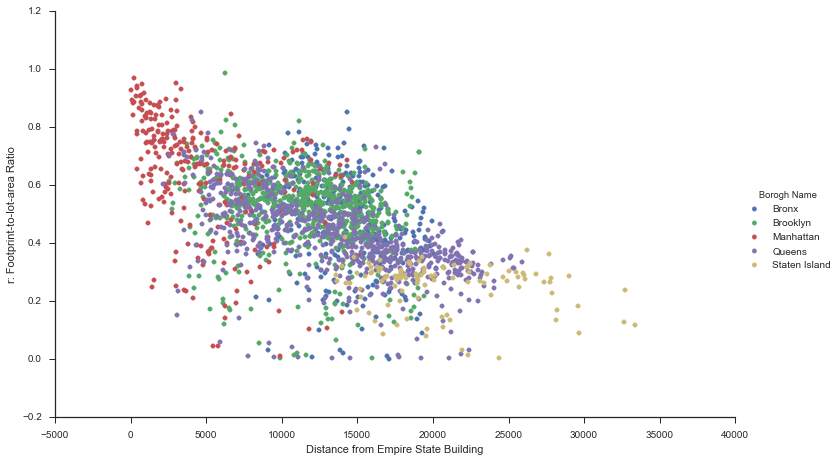

In [58]:
import seaborn

seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'dist_from_esb','r').add_legend(title = 'Borogh Name').set_axis_labels("Distance from Empire State Building", "r: Footprint-to-lot-area Ratio")

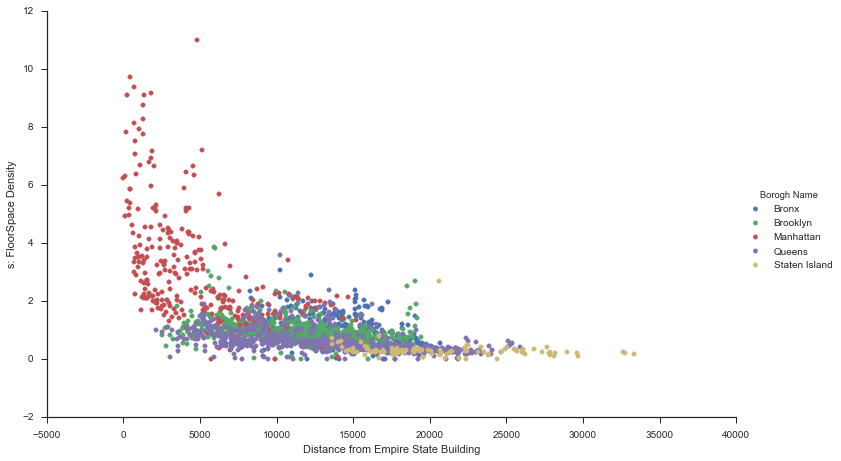

In [59]:
import seaborn

seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'dist_from_esb','s').add_legend(title = 'Borogh Name').set_axis_labels("Distance from Empire State Building", "s: FloorSpace Density")

In [60]:
#final_data.to_csv('final_data.csv')

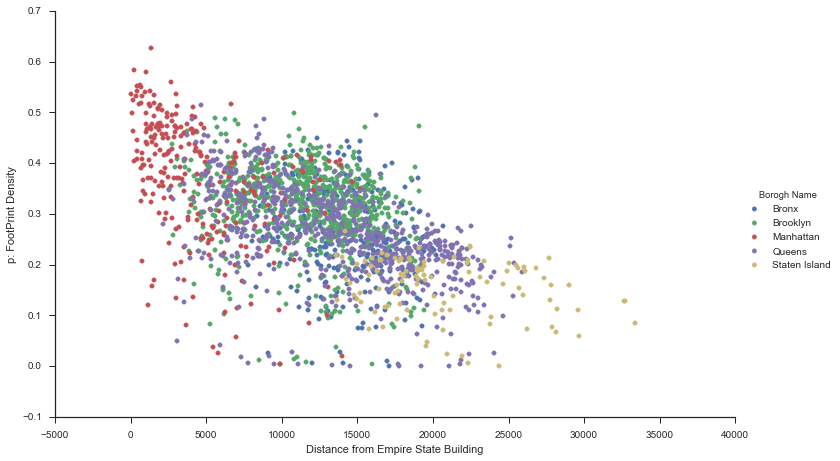

In [61]:
seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'dist_from_esb','p').add_legend(title = 'Borogh Name').set_axis_labels("Distance from Empire State Building", "p: FootPrint Density")

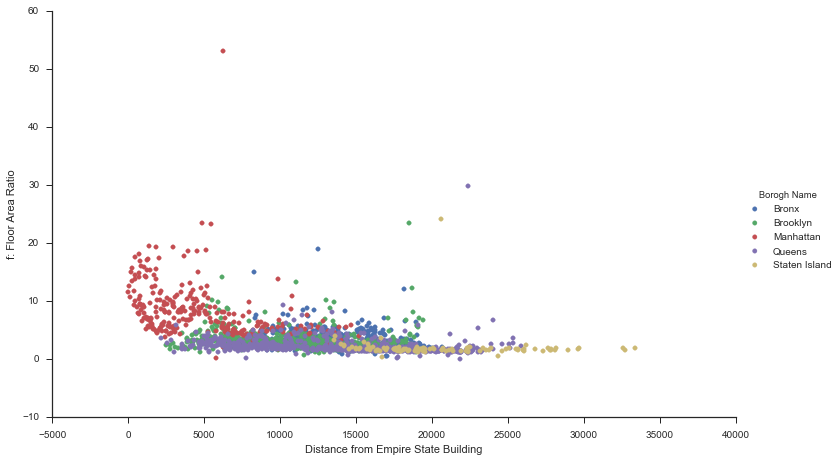

In [62]:
seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'dist_from_esb','f').add_legend(title = 'Borogh Name').set_axis_labels("Distance from Empire State Building", "f: Floor Area Ratio")

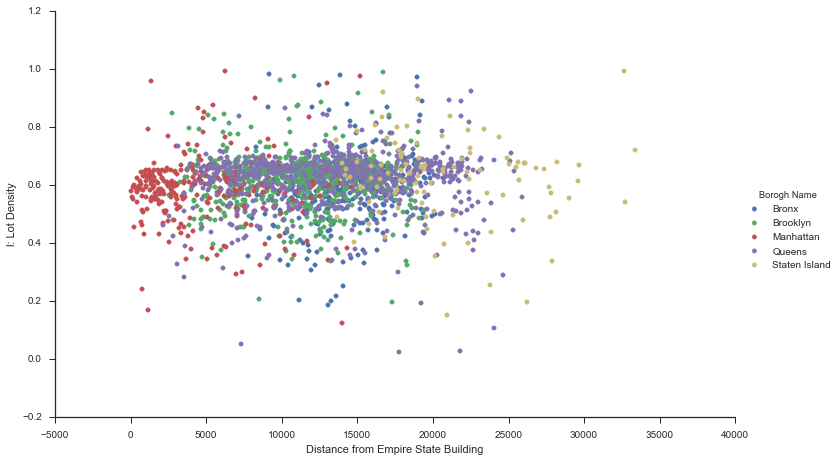

In [63]:
import seaborn

seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'dist_from_esb','l').add_legend(title = 'Borogh Name').set_axis_labels("Distance from Empire State Building", "l: Lot Density")

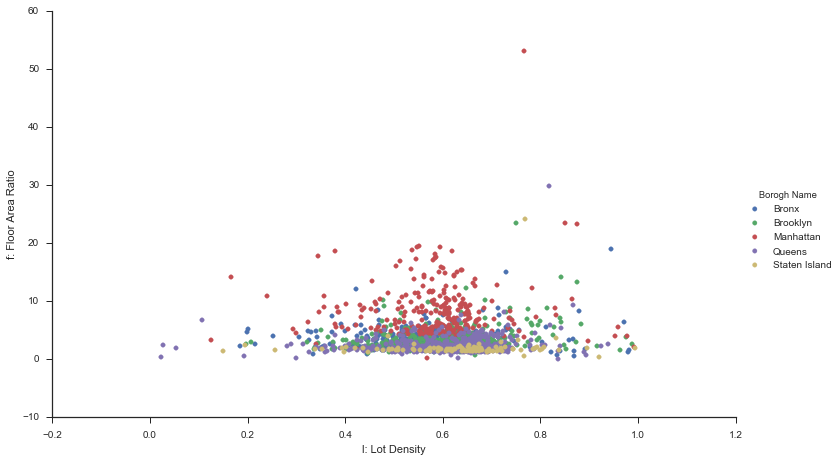

In [64]:
seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'l','f').add_legend(title = 'Borogh Name').set_axis_labels("l: Lot Density", "f: Floor Area Ratio")

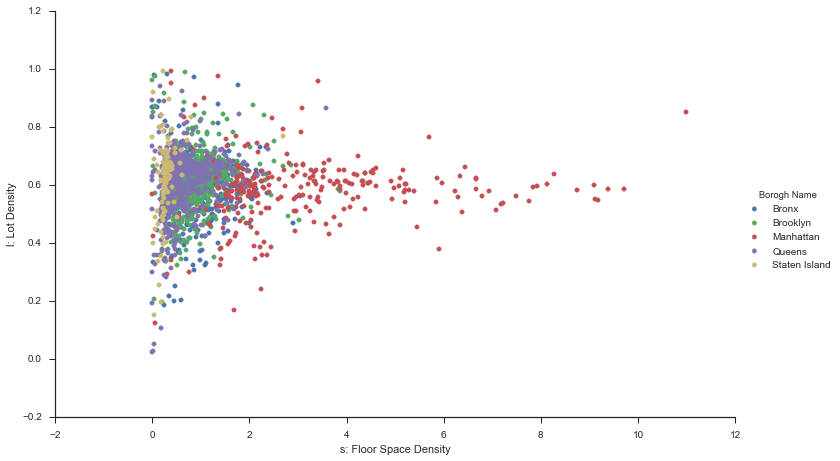

In [65]:
seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'s','l').add_legend(title = 'Borogh Name').set_axis_labels("s: Floor Space Density", "l: Lot Density")

In [233]:
final_data[(final_data['CensusTract']=='1001502') | (final_data['CensusTract']=='1000700')]

,CensusTract,boroname,LotArea,FootPrint,FloorSpace,SurfaceArea,ct_density,dist_from_esb,Neighborhood,floorarea_sqft,s,p,f,l,r,log_dist
3,1000700,Manhattan,2152431,1187126.893830,27771533,2528569.60166,11.133145,4837.180732,Battery Park City-Lower Manhattan,28150931,10.9831,0.4695,23.3939,0.8512,0.5515,8.484087
12,1001502,Manhattan,1385593,930601.076508,13957267,2201257.30611,6.351769,4609.677359,Battery Park City-Lower Manhattan,13981877,6.3406,0.4228,14.9981,0.6295,0.6716,8.435913


In [143]:
print final_data[['s','p','f','l','r','dist_from_esb']].corr()

                      s         p         f         l         r  dist_from_esb
s              1.000000  0.579170  0.814016 -0.012286  0.588780      -0.582457
p              0.579170  1.000000  0.226434  0.131625  0.897257      -0.542524
f              0.814016  0.226434  1.000000 -0.015822  0.271810      -0.469217
l             -0.012286  0.131625 -0.015822  1.000000 -0.262067       0.077871
r              0.588780  0.897257  0.271810 -0.262067  1.000000      -0.582250
dist_from_esb -0.582457 -0.542524 -0.469217  0.077871 -0.582250       1.000000


In [144]:
# Let's fit the logit.
mod = smf.ols(formula=' dist_from_esb ~ s + p + f + l + r', data = final_data).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:          dist_from_esb   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     341.5
Date:                Mon, 02 May 2016   Prob (F-statistic):          2.73e-268
Time:                        20:37:26   Log-Likelihood:                -20523.
No. Observations:                2110   AIC:                         4.106e+04
Df Residuals:                    2104   BIC:                         4.109e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.296e+04   1152.181     19.931      0.0

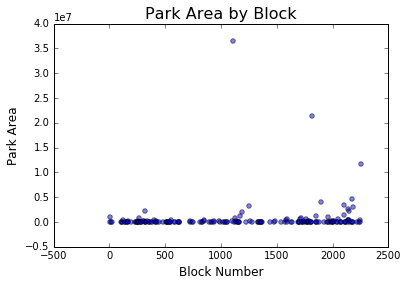

In [17]:
plt.figure(figsize=(6, 4))
plt.scatter(data2.Block,data2.Park_Area,alpha = .5, s = 20)
plt.xlabel('Block Number', fontsize = 12)
plt.ylabel('Park Area', fontsize = 12)
plt.title('Park Area by Block', fontsize = 16)

In [18]:
import statsmodels.api as sm
y = data2.Park_Area
x = data2.Total_Area
X = sm.add_constant(x)
#print X
model = sm.OLS(y, X, missing='drop') # ignores entires where x or y is NaN
fit = model.fit()
fit.params[1], fit.params[0] # could also return stderr in each via fit.bse

(0.93893897435410967, -204431.79611967353)

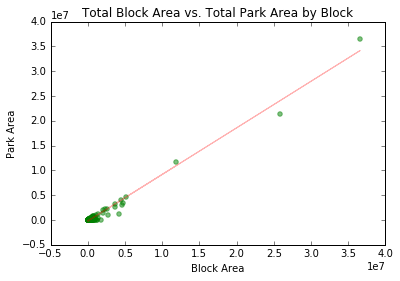

In [19]:
#fit and plots here
plt.figure(figsize=(6, 4))
xlabel('Block Area')
ylabel('Park Area')
plt.title('Total Block Area vs. Total Park Area by Block')
plt.scatter(x, y, alpha=.5, s=20, color = 'g')
plt.plot(x, fit.params[1]*x + fit.params[0], '-', color = 'r', alpha = .3)
plt.show()

In [20]:
#data.to_csv('Park_Area_Block.csv')

In [62]:
Park= pd.read_csv('Park_Area_Block.csv')
Park = Park[['Block','Total_Area','Park_Area','park_ratio']]
#Park = Park[Park['Park_Area']>0]
Park_DT = Park
Park.head()

,Block,Total_Area,Park_Area,park_ratio
0,1,11042768,0,0.000000
1,2,949542,0,0.000000
2,3,1142725,1018925,89.166247
3,4,111382,0,0.000000
4,5,108046,0,0.000000


In [91]:
Block_DT = Block_DT.astype(int).tolist()

In [94]:
for i in Block_DT:
    DT_Park[i] = Park[i]

KeyError: 1

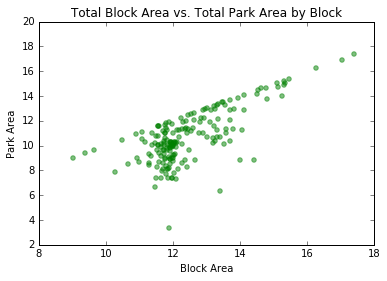

In [56]:
#fit and plots here
x = log(Park.Total_Area)
y = log(Park.Park_Area)
plt.figure(figsize=(6, 4))
xlabel('Block Area')
ylabel('Park Area')
plt.title('Total Block Area vs. Total Park Area by Block')
plt.scatter(x, y, alpha=.5, s=20, color = 'g')
#plt.plot(x, fit.params[1]*x + fit.params[0], '-', color = 'r', alpha = .3)
plt.show()

In [50]:
max (Park['Park_Area'])

36590000.0

In [22]:
#Subset Downtown Manhattan data.
#DM: Downtown Manhattan, Community District as 101, 102, 103.

DM = Mn [(Mn.CD==101)|(Mn.CD==102)|(Mn.CD==103)] 

In [23]:
print "The number of lot in Manhattan Borough is {0}.".format(len (Mn)) 
print "The number of lot in Downtown Manhattan (Community District 101, 102, 103) is {0}.".format(len (DM)) 

The number of lot in Manhattan Borough is 43231.
The number of lot in Downtown Manhattan (Community District 101, 102, 103) is 10564.


In [24]:
DM.columns

Index([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'Address', u'ZoneDist1', u'ZoneDist2', u'ZoneDist3',
       u'ZoneDist4', u'Overlay1', u'Overlay2', u'SPDist1', u'SPDist2',
       u'LtdHeight', u'AllZoning1', u'AllZoning2', u'SplitZone', u'BldgClass',
       u'LandUse', u'Easements', u'OwnerType', u'OwnerName', u'LotArea',
       u'BldgArea', u'ComArea', u'ResArea', u'OfficeArea', u'RetailArea',
       u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea', u'AreaSource',
       u'NumBldgs', u'NumFloors', u'UnitsRes', u'UnitsTotal', u'LotFront',
       u'LotDepth', u'BldgFront', u'BldgDepth', u'Ext', u'ProxCode',
       u'IrrLotCode', u'LotType', u'BsmtCode', u'AssessLand', u'AssessTot',
       u'ExemptLand', u'ExemptTot', u'YearBuilt', u'BuiltCode', u'YearAlter1',
       u'YearAlter2', u'HistDist', u'Landmark', u'BuiltFAR', u'ResidFAR',
       u'CommFAR', u'FacilFAR', u'

In [25]:
#Now we group lot data by land use types, land use '9' is coded as 'Open Space & Outdoor Recreation'.
LotArea_LandUse = DM.groupby('LandUse').sum().LotArea
print LotArea_LandUse

LandUse
       5651828
1      1093737
10     1187100
11     3705761
2      5443458
3     13887805
4     17535549
5     13640060
6      1812135
7     10192062
8     16103890
9      7721201
Name: LotArea, dtype: float64


In [26]:
#Subset Open Space.
DM_Open = DM [DM.LandUse=='9']
len (DM_Open)

120

In [27]:
#Calculate total lot area of all lots and open space, get the total area of 'Non Open Space'.
Mn_LotArea = sum (DM.LotArea)
OpenArea = sum (DM_Open.LotArea)
Non_OpenArea = Mn_LotArea - OpenArea 
print "Total lot area in Downtown Manhattan is {0} square feet.".format(Mn_LotArea) 
print "Open space lot area in Downtown Manhattan is {0} square feet.".format(OpenArea) 
#print "Open space ratio in Downtown Manhattan is {0}%.".format((ParkArea/Mn_LotArea)*100 )

Total lot area in Downtown Manhattan is 97974586.0 square feet.
Open space lot area in Downtown Manhattan is 7721201.0 square feet.


In [28]:
#Now we calculate total Land Area of Downtown Manhattan.
CD101 = 32979565
CD102 = 37720826
CD103 = 46882431
Mn_LandArea = CD101+CD102+CD103
print "Therefore,"
print "Total land area in Downtown Manhattan is: {0} square feet.".format(Mn_LandArea) 
print "Total non open space lot area in Downtown Manhattan is: {0} square feet.".format(Non_OpenArea) 
print "Open space area in Downtown Manhattan is: {0} square feet.".format(Mn_LandArea-Non_OpenArea) 
print 
print "Open space area ratio in Downtown Manhattan is: {0}%.".format((Mn_LandArea-Non_OpenArea)/Mn_LandArea*100) 

Therefore,
Total land area in Downtown Manhattan is: 117582822 square feet.
Total non open space lot area in Downtown Manhattan is: 90253385.0 square feet.
Open space area in Downtown Manhattan is: 27329437.0 square feet.

Open space area ratio in Downtown Manhattan is: 23.2427122731%.


In [29]:
#We can also use Zoning code 'Park' to subset public space.
print 'All unique Zoning Code in Manhattan:'
print Mn.ZoneDist1.unique()

All unique Zoning Code in Manhattan:
['R3-2     ' 'ZNA      ' 'M1-4     ' 'C4-6     ' 'PARK     ' 'C5-5     '
 '         ' 'C6-4     ' 'BPC      ' 'M2-3     ' 'C6-9     ' 'C5-3     '
 'R8       ' 'C6-2A    ' 'R7-2     ' 'C6-3     ' 'C6-3A    ' 'C6-4A    '
 'C6-1     ' 'C6-1G    ' 'M1-5     ' 'C6-2G    ' 'M1-5B    ' 'M1-6     '
 'M1-5A    ' 'C2-8     ' 'C8-4     ' 'C6-2     ' 'R7A      ' 'R8A      '
 'C4-4A    ' 'M3-2     ' 'R8B      ' 'C1-6A    ' 'R7B      ' 'R8X      '
 'C1-7A    ' 'C1-9A    ' 'R6       ' 'C1-7     ' 'C2-6     ' 'R10      '
 'C4-5     ' 'C6-3X    ' 'C1-6     ' 'C6-2M    ' 'C6-4M    ' 'M2-4     '
 'M1-5/R7X ' 'C2-7     ' 'R6A      ' 'C6-5     ' 'C6-6     ' 'C6-7     '
 'C2-6A    ' 'C2-7A    ' 'M1-6D    ' 'C6-4X    ' 'C6-4.5   ' 'C5-2     '
 'M1-5M    ' 'R9X      ' 'C5-2.5   ' 'R9A      ' 'C2-8A    ' 'C4-5A    '
 'C1-9     ' 'C1-8A    ' 'R9       ' 'C1-8     ' 'M1-1     ' 'C6-7T    '
 'C6-5.5   ' 'C6-6.5   ' 'C5-1     ' 'R10H     ' 'C4-7     ' 'R10A     '
 'C4-6A    ' '

In [30]:
#Subset lot defined by zoning code 'Park':
Mn_Park = Mn[Mn.ZoneDist1 =='PARK     ']
len (Mn_Park)

269

In [31]:
ParkArea = sum (Mn_Park.LotArea)
print "Total lot area in Downtown Manhattan is {0} square feet.".format(Mn_LotArea) 
print "Park lot area in Downtown Manhattan is {0} square feet.".format(ParkArea) 
print "Park lot area ratio in Downtown Manhattan is {0}%.".format((ParkArea/Mn_LotArea)*100 )

Total lot area in Downtown Manhattan is 97974586.0 square feet.
Park lot area in Downtown Manhattan is 118032766.0 square feet.
Park lot area ratio in Downtown Manhattan is 120.472839763%.


In [32]:
#This is incorrect since the park area is bigger than total lot area! 
#Therefore we are suspicious about if there is any incorrect data, 
#especially some lot with worng, extremly large lot area.

print "The largest park lot in Downtown Manhattan is {0} square feet, which is {1}% of total land area.".format(max (Mn_Park.LotArea), (max (Mn_Park.LotArea)/Mn_LotArea)*100)

The largest park lot in Downtown Manhattan is 36590000.0 square feet, which is 37.3464196113% of total land area.


__Conclusion:__ Based on common kownledge, we know there is no one lot park area as 37% of total land area in Downtown Manhattan.